<a href="https://colab.research.google.com/github/Kritika1303/Zeotap_assignment/blob/main/Kritika_Kritika_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Importing Libraries***

In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull
import numpy as np

***Load and Merge datasets***

In [3]:
# Load the datasets
customers = pd.read_csv('/content/drive/MyDrive/Zeotap_Assignment/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Zeotap_Assignment/Transactions.csv')
# Merge customer and transaction data
merged_data = pd.merge(customers, transactions, on='CustomerID', how='inner')

merged_data

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64
...,...,...,...,...,...,...,...,...,...,...
995,C0200,Kelly Cross,Asia,2023-06-11,T00518,P034,2024-12-11 03:05:50,4,868.20,217.05
996,C0200,Kelly Cross,Asia,2023-06-11,T00091,P057,2024-04-27 19:06:20,1,239.70,239.70
997,C0200,Kelly Cross,Asia,2023-06-11,T00731,P061,2024-07-15 20:36:28,4,627.84,156.96
998,C0200,Kelly Cross,Asia,2023-06-11,T00771,P048,2024-09-10 09:50:48,4,1665.60,416.40


***Data Preparation and Aggregation***

In [4]:
# Aggregate transaction data
customer_agg = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',                     # Total spending
    'TransactionID': 'count',                # Transaction frequency
    'Quantity': 'sum',                       # Total quantity purchased
    'Price': 'mean'                          # Average price of products
}).reset_index()

# Rename columns
customer_agg.rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionFrequency',
    'Quantity': 'TotalQuantity',
    'Price': 'AvgPrice'
}, inplace=True)

# Merge aggregated transaction data with customer profile
segmentation_data = pd.merge(customers, customer_agg, on='CustomerID')

***Normalisation***

In [6]:
# Select numeric features for clustering
numeric_features = ['TotalSpending', 'TransactionFrequency', 'TotalQuantity', 'AvgPrice']
scaler = StandardScaler()
segmentation_data_scaled = scaler.fit_transform(segmentation_data[numeric_features])

***Clustering Algorithms***

1. KMeans

In [43]:
# Choose the number of clusters (k)
kmeans = KMeans(n_clusters=4, random_state=49)
segmentation_data['Cluster'] = kmeans.fit_predict(segmentation_data_scaled)

# Calculate DB Index and silhouette score
db_index = davies_bouldin_score(segmentation_data_scaled, segmentation_data['Cluster'])
silhouette = silhouette_score(segmentation_data_scaled, segmentation_data['Cluster'])

print(f"KMeans - Davies-Bouldin Index: {db_index}")
print(f"KMeans - Silhouette Score: {silhouette}")

KMeans - Davies-Bouldin Index: 0.9350665467724448
KMeans - Silhouette Score: 0.3280792561471826


2. Agglomerative Clustering

In [28]:
# Perform Hierarchical clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(segmentation_data_scaled)

# Calculate metrics
db_index_hierarchical = davies_bouldin_score(segmentation_data_scaled, agg_labels)
silhouette_hierarchical = silhouette_score(segmentation_data_scaled, agg_labels)

print(f"Hierarchical - Davies-Bouldin Index: {db_index_hierarchical}")
print(f"Hierarchical - Silhouette Score: {silhouette_hierarchical}")

Hierarchical - Davies-Bouldin Index: 1.0309987258045574
Hierarchical - Silhouette Score: 0.29589376544931617


3. Gaussian Mixture Model (GMM)

In [50]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(features)

# Add GMM cluster labels to the DataFrame
viz_df['GMM_Cluster'] = gmm_labels

# Calculate metrics
gmm_db_index = davies_bouldin_score(features, gmm_labels)
gmm_silhouette = silhouette_score(features, gmm_labels)

print(f"GMM - Davies-Bouldin Index : {gmm_db_index}")
print(f"GMM - Silhouette Score : {gmm_silhouette}")

GMM - Davies-Bouldin Index : 1.2267576544072196
GMM - Silhouette Score : 0.27464610642613446


On comparison KMeans(k=4) gives the best results, therefore visualisation is based on KMeans clustering algorithm

***Visualisation***

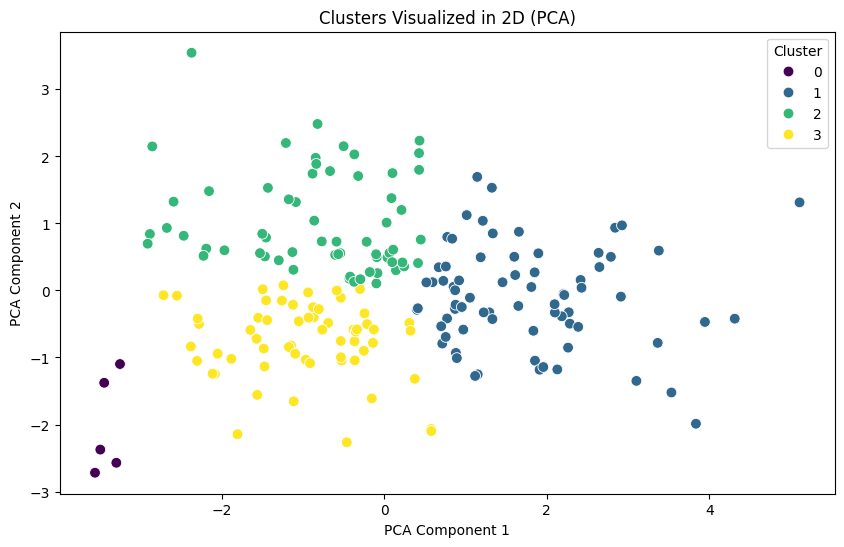

In [37]:
kmeans = KMeans(n_clusters=4, random_state=49)
labels = kmeans.fit_predict(features)

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Create a DataFrame for visualization
viz_df = pd.DataFrame(features_2d, columns=['PCA1', 'PCA2'])
viz_df['Cluster'] = labels

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=viz_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=60)
plt.title('Clusters Visualized in 2D (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

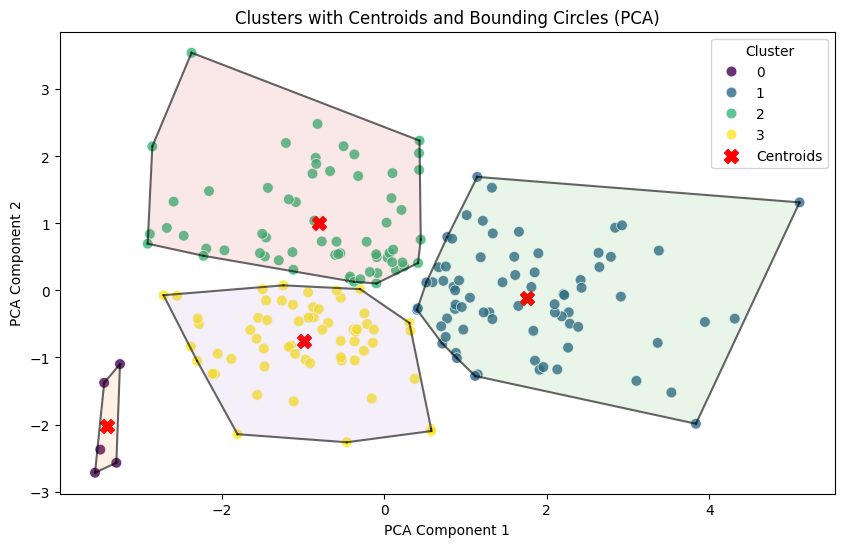

In [40]:
# Clusters with centroids and bounding circles
plt.figure(figsize=(10, 6))
sns.scatterplot(data=viz_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=60, alpha=0.8)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='X', s=100, label='Centroids')

# Calculate and draw bounding circles for each cluster
for cluster in range(4):                                                              # Iterate through clusters
    cluster_points = viz_df[viz_df['Cluster'] == cluster][['PCA1', 'PCA2']].values
    if len(cluster_points) >= 3:                                                      # ConvexHull requires at least 3 points
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', alpha=0.6)
        # Optionally fill the convex hull (for visualization purposes)
        plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], alpha=0.1)

plt.title('Clusters with Centroids and Bounding Circles (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

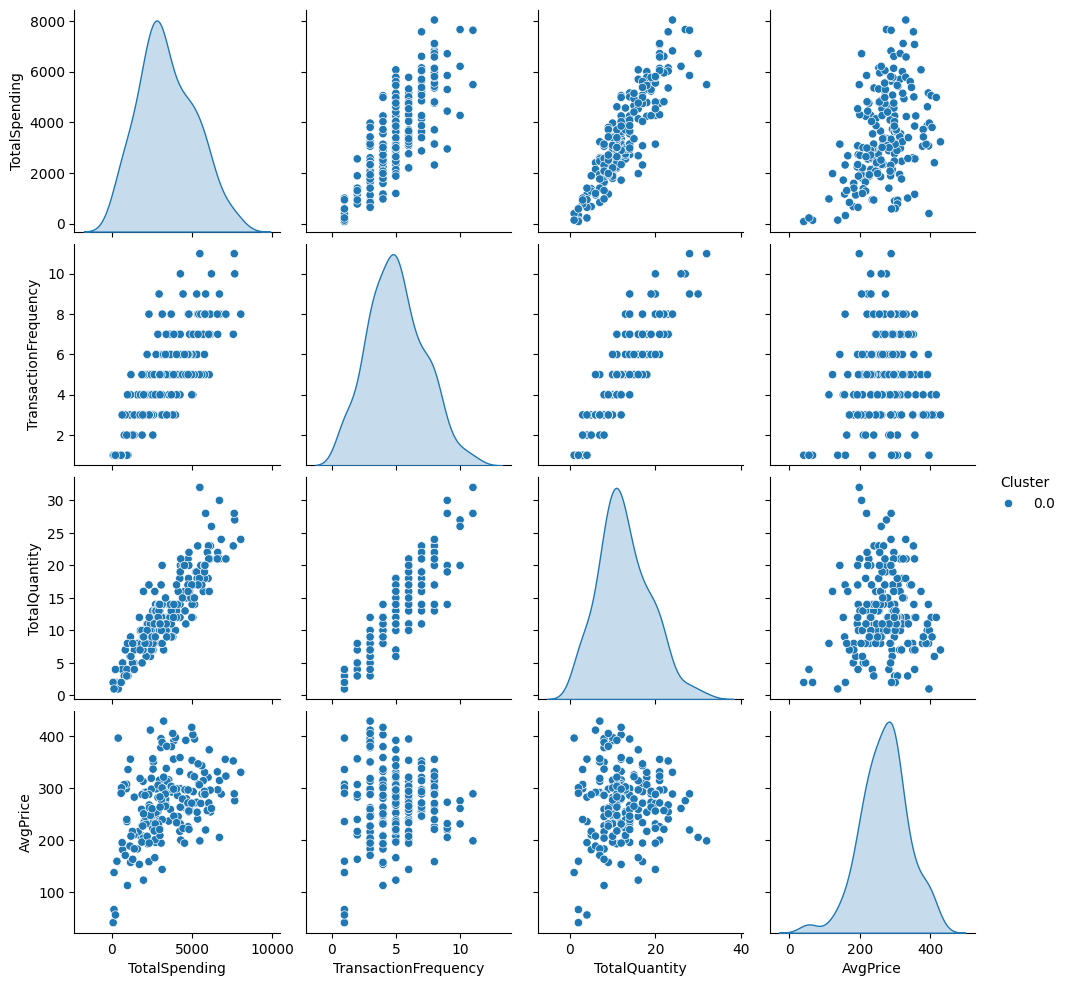

In [14]:
# Pairplot for visualizing pairwise relationships between numerical features
sns.pairplot(segmentation_data, vars=numeric_features, hue='Cluster', palette='tab10')
plt.show()